# RESEGMENTATION PIPELINE

## Set up source and destination folders

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, box


In [20]:
ddir = 'D:\Alexis\Projects\SpatialOmics_cellpose\\results'
base_path = "D:\Alexis\Projects\SpatialOmics_cellpose\data5k\output-XETG00245__0041374__Section_3_1888OD__20250326__175738"
# Select first and third hannels for segmentation (can only select three) 
fullres_chanel_0 = f"{base_path}\morphology_focus\morphology_focus_0000.ome.tif"   
fullres_chanel_2 = f"{base_path}\morphology_focus\morphology_focus_0002.ome.tif"
# fullres_chanel_3 = f"{base_path}\morphology_focus\morphology_focus_0003.ome.tif"

sample_name = "1888od"

# comment out if don't have ROI
ROI_filepath = f"{base_path}\{sample_name}_coords.csv"

# Levels: pixelsize in µm https://kb.10xgenomics.com/hc/en-us/articles/11636252598925
scalefactors = {
    0: 0.2125,
    1: 0.4250,
    2: 0.85,
    3: 1.7,
    4: 3.4,
    5: 6.8,
    6: 13.6,
    7: 27.2,
}

# Define resolution level and crop size in pixels
level = 0
pixelsize = scalefactors[level]

# Define patch size
crop_size = 600/pixelsize

## Define the region of interest (ROI)

In [9]:

def get_all_sections(filepath):
    """Simple parser for ROI file"""
    
    # Skip the header rows and read the data
    coords = pd.read_csv(filepath, skiprows=2)
    
    # Get all unique sections
    sections = coords['Selection'].unique()
    
    print(f"Found {len(sections)} sections:")
    
    all_sections = []
    
    for section in sections:
        section_data = coords[coords['Selection'] == section]
        
        section_info = {
            'name': section,
            'x_coords': section_data['X'].values,
            'y_coords': section_data['Y'].values,
            'num_points': len(section_data)
        }
        
        all_sections.append(section_info)
        print(f"  - {section}: {len(section_data)} points")
    
    return all_sections

def plot_all_sections(all_sections):
    """Plot all sections"""
    
    plt.figure(figsize=(12, 8))
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']
    
    for i, section in enumerate(all_sections):
        color = colors[i % len(colors)]
        
        plt.plot(section['x_coords'], section['y_coords'], 
                'o-', color=color, markersize=3, 
                label=f"{section['name']} ({section['num_points']} pts)", 
                alpha=0.8, linewidth=2)
        
        # Close polygon
        if section['num_points'] > 2:
            plt.plot([section['x_coords'][0], section['x_coords'][-1]], 
                    [section['y_coords'][0], section['y_coords'][-1]], 
                    '-', color=color, alpha=0.8, linewidth=2)
    
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('All ROI Sections')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

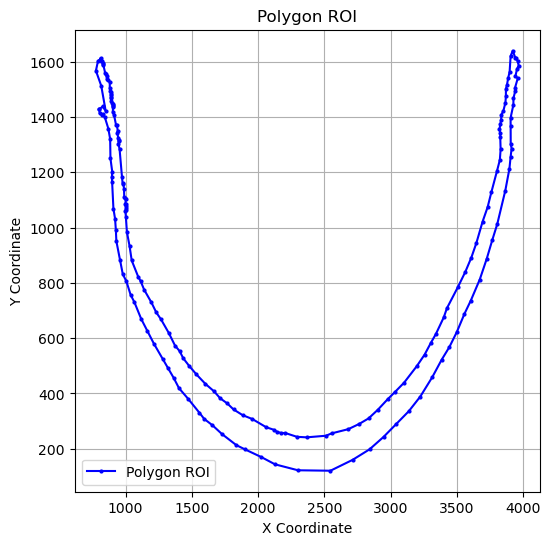

In [15]:
# Read the ROI coordinates from the CSV file
from src.core.crop_image import *

# TODO: Comment out if dont have ROI
plot_roi(ROI_filepath)
polygon_coords = pd.read_csv(ROI_filepath)

# polygon_coords = all_sections

# Extract the X and Y coordinates
x_coords = polygon_coords['X']
y_coords = polygon_coords['Y']


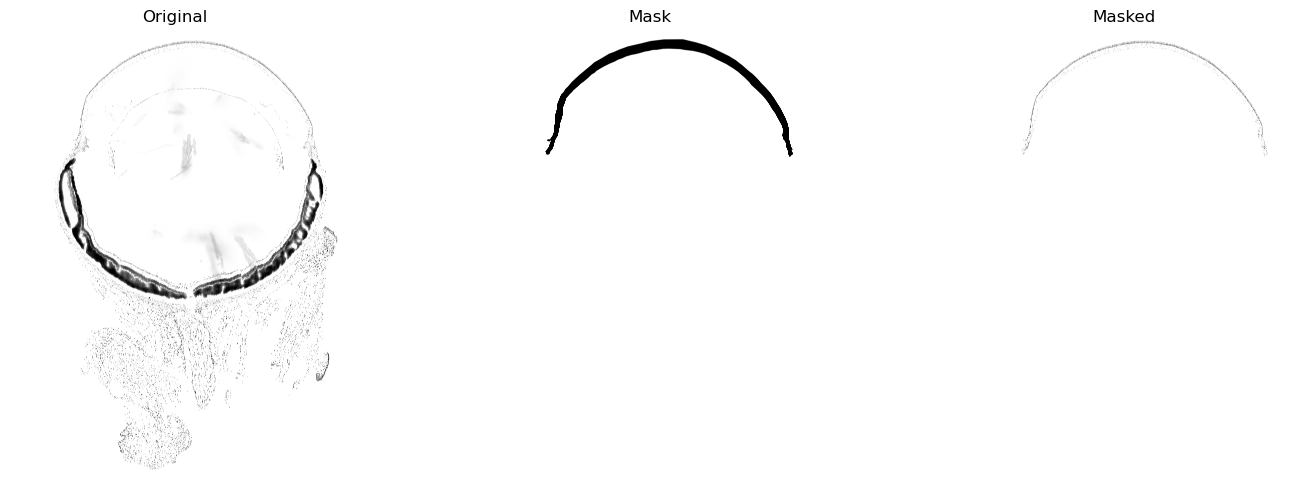

In [16]:
mask, masked_img_0 = mask_polygon_from_tif(
    fullres_chanel_0,
    x_coords, y_coords,
    scalefactors,
    level=0,
    plot=True
)

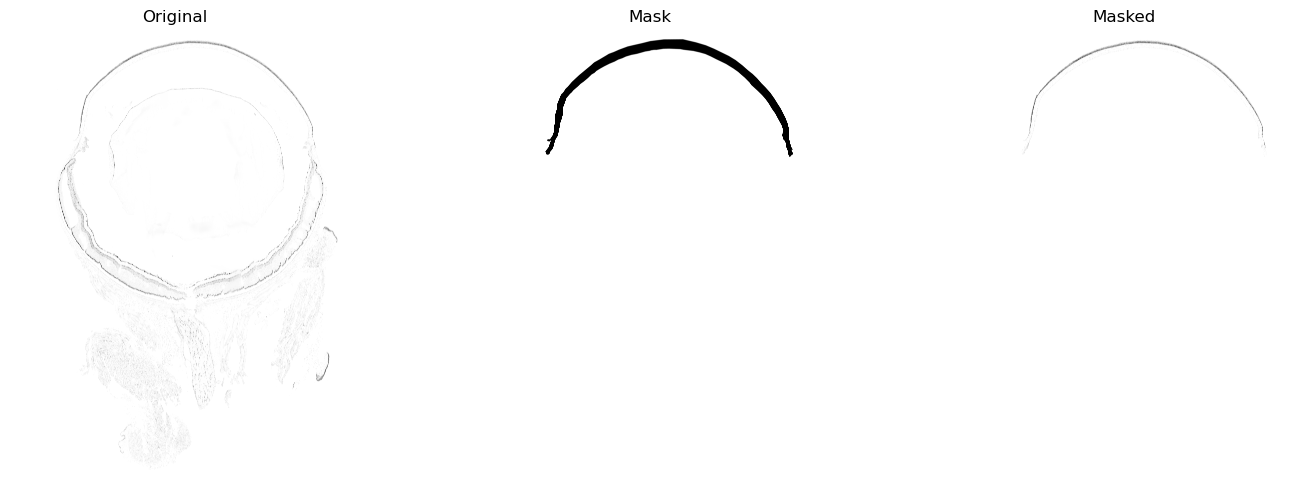

In [21]:
mask, masked_img_2 = mask_polygon_from_tif(
    fullres_chanel_2,
    x_coords, y_coords,
    scalefactors,
    level=0,
    plot=True
)

In [22]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

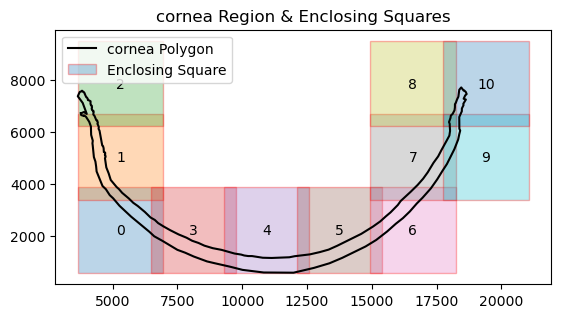

In [23]:
# Combine X and Y into coordinate pairs
x_coords_rescaled = x_coords / pixelsize
y_coords_rescaled = y_coords / pixelsize
rescaled_polygon_roi = list(zip(x_coords_rescaled, y_coords_rescaled))

# Create a Polygon object
rescaled_polygon_roi = Polygon(rescaled_polygon_roi)

# Define square size
square_size = int(crop_size)
overlap_size = 100/0.2125

# Generate non-overlapping square regions
overlapping_squares = crop_polygon_to_squares(rescaled_polygon_roi, square_size, overlap_size=overlap_size, with_overlap=True)
non_overlapping_squares = crop_polygon_to_squares(rescaled_polygon_roi, square_size, with_overlap=False)


plot_polygon_and_squares(
    rescaled_polygon_roi,
    overlapping_squares,
    title="cornea Region & Enclosing Squares",
    polygon_label="cornea Polygon",
    square_label="Enclosing Square"
)

# for square in overlapping_squares:
#     print("square:", square)
#     x, y = square.exterior.xy
#     print(" x:", x,"\n", "y:", y)


## CELLPOSE - SEGMENTATION

In [25]:
from src.core.segmentation_cp import *




Welcome to CellposeSAM, cellpose v
cellpose version: 	4.0.4 
platform:       	win32 
python version: 	3.11.10 
torch version:  	2.7.1+cu126! The neural network component of
CPSAM is much larger than in previous versions and CPU excution is slow. 
We encourage users to use GPU/MPS if available. 




In [26]:
model = models.CellposeModel(gpu=True,
                             pretrained_model='D:\Alexis\Projects\SpatialOmics_cellpose\models\cpsam_DED'
                             )

In [27]:
# Example usage
total = process_images_in_folder(
    input_folder = f'{ddir}/cropped_image/{sample_name}',      
    output_folder = f'{ddir}/segmenatation/{sample_name}',
    cellpose_model = model
)

print(f"Total cells detected: {total}")

channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Processing file: cropped_square_com_1.tif, shape: (2, 3011, 3011)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_1.tif: 198


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_1.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/1888od\cropped_square_com_1

Processing file: cropped_square_com_10.tif, shape: (2, 3011, 2212)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_10.tif: 100


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_10.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/1888od\cropped_square_com_10

Processing file: cropped_square_com_2.tif, shape: (2, 3011, 3011)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_2.tif: 265


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_2.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/1888od\cropped_square_com_2

Processing file: cropped_square_com_3.tif, shape: (2, 3011, 3011)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_3.tif: 145


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_3.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/1888od\cropped_square_com_3

Processing file: cropped_square_com_4.tif, shape: (2, 3011, 3011)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_4.tif: 334


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_4.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/1888od\cropped_square_com_4

Processing file: cropped_square_com_5.tif, shape: (2, 3011, 3011)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_5.tif: 337


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_5.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/1888od\cropped_square_com_5

Processing file: cropped_square_com_6.tif, shape: (2, 3011, 3011)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_6.tif: 332


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_6.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/1888od\cropped_square_com_6

Processing file: cropped_square_com_7.tif, shape: (2, 3011, 3011)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_7.tif: 233


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_7.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/1888od\cropped_square_com_7

Processing file: cropped_square_com_8.tif, shape: (2, 3011, 3011)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_8.tif: 191


channels deprecated in v4.0.1+. If data contain more than 3 channels, only the first 3 channels will be used


Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_8.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/1888od\cropped_square_com_8

Processing file: cropped_square_com_9.tif, shape: (2, 3011, 2212)
Mask Segmentation Down!
Number of detected regions in cropped_square_com_9.tif: 121
Segmentation output saved to 'segmented_output_seg.npy'
Output of [cropped_square_com_9.tif] saved as: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/1888od\cropped_square_com_9

Total cells detected: 2256


## Merge

In [28]:
from src.core.merge import *

In [29]:
ROI_filepath = f"{base_path}\{sample_name}_coords.csv"

In [ ]:
input_dir = f"{ddir}/segmenatation/{sample_name}"

# 1. Load and offset centroids
centroids_dict = load_and_offset_centroids(input_dir, overlapping_squares)

# 2. Find duplicate cells in overlap zones (NEW STEP)
duplicate_groups = find_duplicate_cells(centroids_dict, overlapping_squares, distance_threshold=50)

# 3. Merge duplicate cells and get mapping (NEW STEP)
merged_cells = merge_duplicate_cells(duplicate_groups, input_dir, overlapping_squares, centroids_dict)

# 4. Map centroids to non-overlapping regions
mapped_df, outside_df, cell_mapping = map_centroids_to_nonoverlapping(centroids_dict, non_overlapping_squares)

# 5. Apply merging to remove duplicates from cell_mapping (NEW STEP)
cell_mapping = apply_cell_merging_to_mapping(cell_mapping, merged_cells)

# 6. Load and map outlines (using updated cell_mapping without duplicates)
filtered_outlines_list, outline_info = map_and_filter_outlines(input_dir, overlapping_squares, cell_mapping)


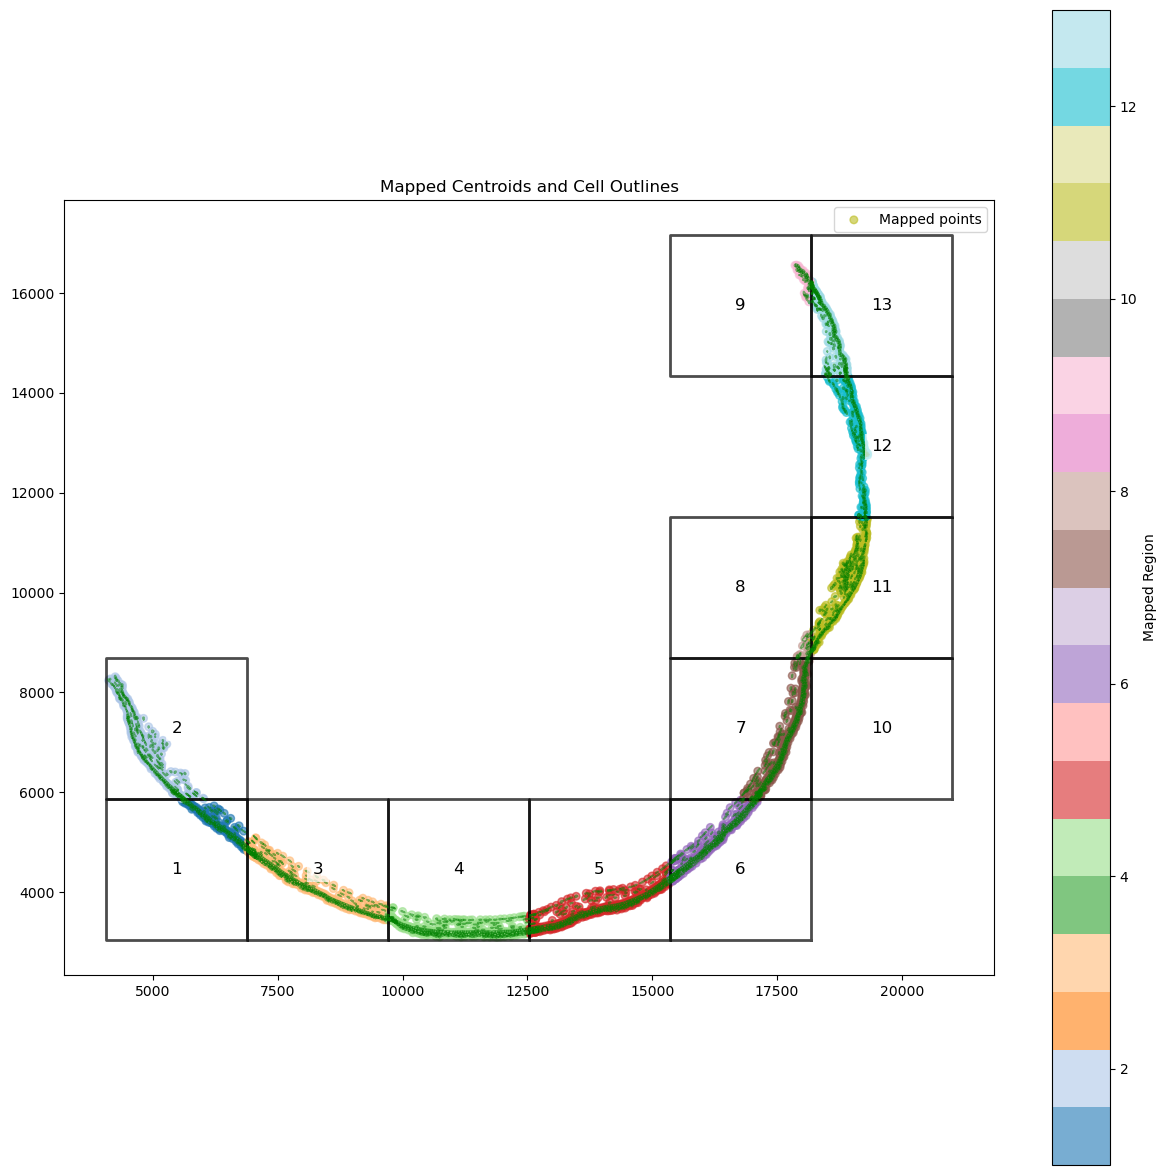


Results saved to: D:\Alexis\Projects\SpatialOmics_cellpose\results/segmenatation/1902od


In [ ]:
# 4. Visualize results
visualize_mapped_data(mapped_df, outside_df, filtered_outlines_list, non_overlapping_squares)

# 5. Save results
output_dir = input_dir
mapped_df.to_csv(os.path.join(output_dir, 'mapped_centroids.csv'), index=False)
if not outside_df.empty:
    outside_df.to_csv(os.path.join(output_dir, 'unmapped_centroids.csv'), index=False)
outline_info.to_csv(os.path.join(output_dir, 'outline_mapping.csv'), index=False)
print(f"\nResults saved to: {output_dir}")

In [ ]:
# Function to map segmentation outlines back to original coordinates
def map_to_original_coordinates(outlines, offset):

    min_x, min_y = offset
    
    return [outline + np.array([min_x, min_y]) for outline in outlines]

outlines_list = []


# Example processing loop for 3 cropped regions
for i, square in enumerate(overlapping_squares):
    
    # Stop the loop when i = 30 if 6 picture, set i + 1 = 5
    if i + 1 == 29:
        i1 = i + 1
        print("Reached the stopping condition: number = {i1}. Exiting the loop.")
        break

    print(f"Processing square {i + 1}: {square}")
    
    # Get bounding box of the current polygon (cropped region)
    min_x, min_y, max_x, max_y = map(int, square.bounds)

    # Load the segmentation result for the cropped region
    # segmentation_file = f"{ddir}/segmenatation/{sample_name}/cropped_square_com_{i + 1}_seg.npy"
    segmentation_file = f"{ddir}/segmenatation/{sample_name}/cropped_square_com_{i + 1}_seg.npy"
    segmentation_data = np.load(segmentation_file, allow_pickle=True).item()
    
    # Extract outlines from    the segmentation
    outlines = utils.outlines_list(segmentation_data['masks'])

    # Map outlines back to original coordinates
    mapped_outlines = map_to_original_coordinates(outlines, (min_x, min_y))
    outlines_list.extend(mapped_outlines)

Processing square 1: POLYGON ((7077.235294117647 3044, 7077.235294117647 6055.235294117647, 4066 6055.235294117647, 4066 3044, 7077.235294117647 3044))
Processing square 2: POLYGON ((7077.235294117647 5867, 7077.235294117647 8878.235294117647, 4066 8878.235294117647, 4066 5867, 7077.235294117647 5867))
Processing square 3: POLYGON ((9900.235294117647 3044, 9900.235294117647 6055.235294117647, 6889 6055.235294117647, 6889 3044, 9900.235294117647 3044))
Processing square 4: POLYGON ((12723.235294117647 3044, 12723.235294117647 6055.235294117647, 9712 6055.235294117647, 9712 3044, 12723.235294117647 3044))
Processing square 5: POLYGON ((15546.235294117647 3044, 15546.235294117647 6055.235294117647, 12535 6055.235294117647, 12535 3044, 15546.235294117647 3044))
Processing square 6: POLYGON ((18369.235294117647 3044, 18369.235294117647 6055.235294117647, 15358 6055.235294117647, 15358 3044, 18369.235294117647 3044))
Processing square 7: POLYGON ((18369.235294117647 5867, 18369.235294117647 

In [ ]:
 # reuse previous function

In [ ]:
df_outlines_list = boundaries_to_table(outlines_list)

import pandas as pd

def close_cell_boundaries(df):
    closed_df = []

    for cell_id, group in df.groupby('cell_id'):
        group_closed = pd.concat([group, group.iloc[[0]]])  # Append first row at end
        closed_df.append(group_closed)

    return pd.concat(closed_df).reset_index(drop=True)

df_outlines_list = close_cell_boundaries(df_outlines_list)



In [ ]:
df_outlines_list.to_csv(f"{ddir}/segmenatation/{sample_name}/cellpose_cell_boundaries_origian_{sample_name}.csv", index=False)
print("Saved successly" )

Saved successly


In [ ]:
# Apply the function
reduced_outlines_list = reduce_points(df_outlines_list)

# Print the results
print("Original shape:", df_outlines_list.shape)
print("Reduced shape:", reduced_outlines_list.shape)

Original shape: (340117, 3)
Reduced shape: (214777, 3)


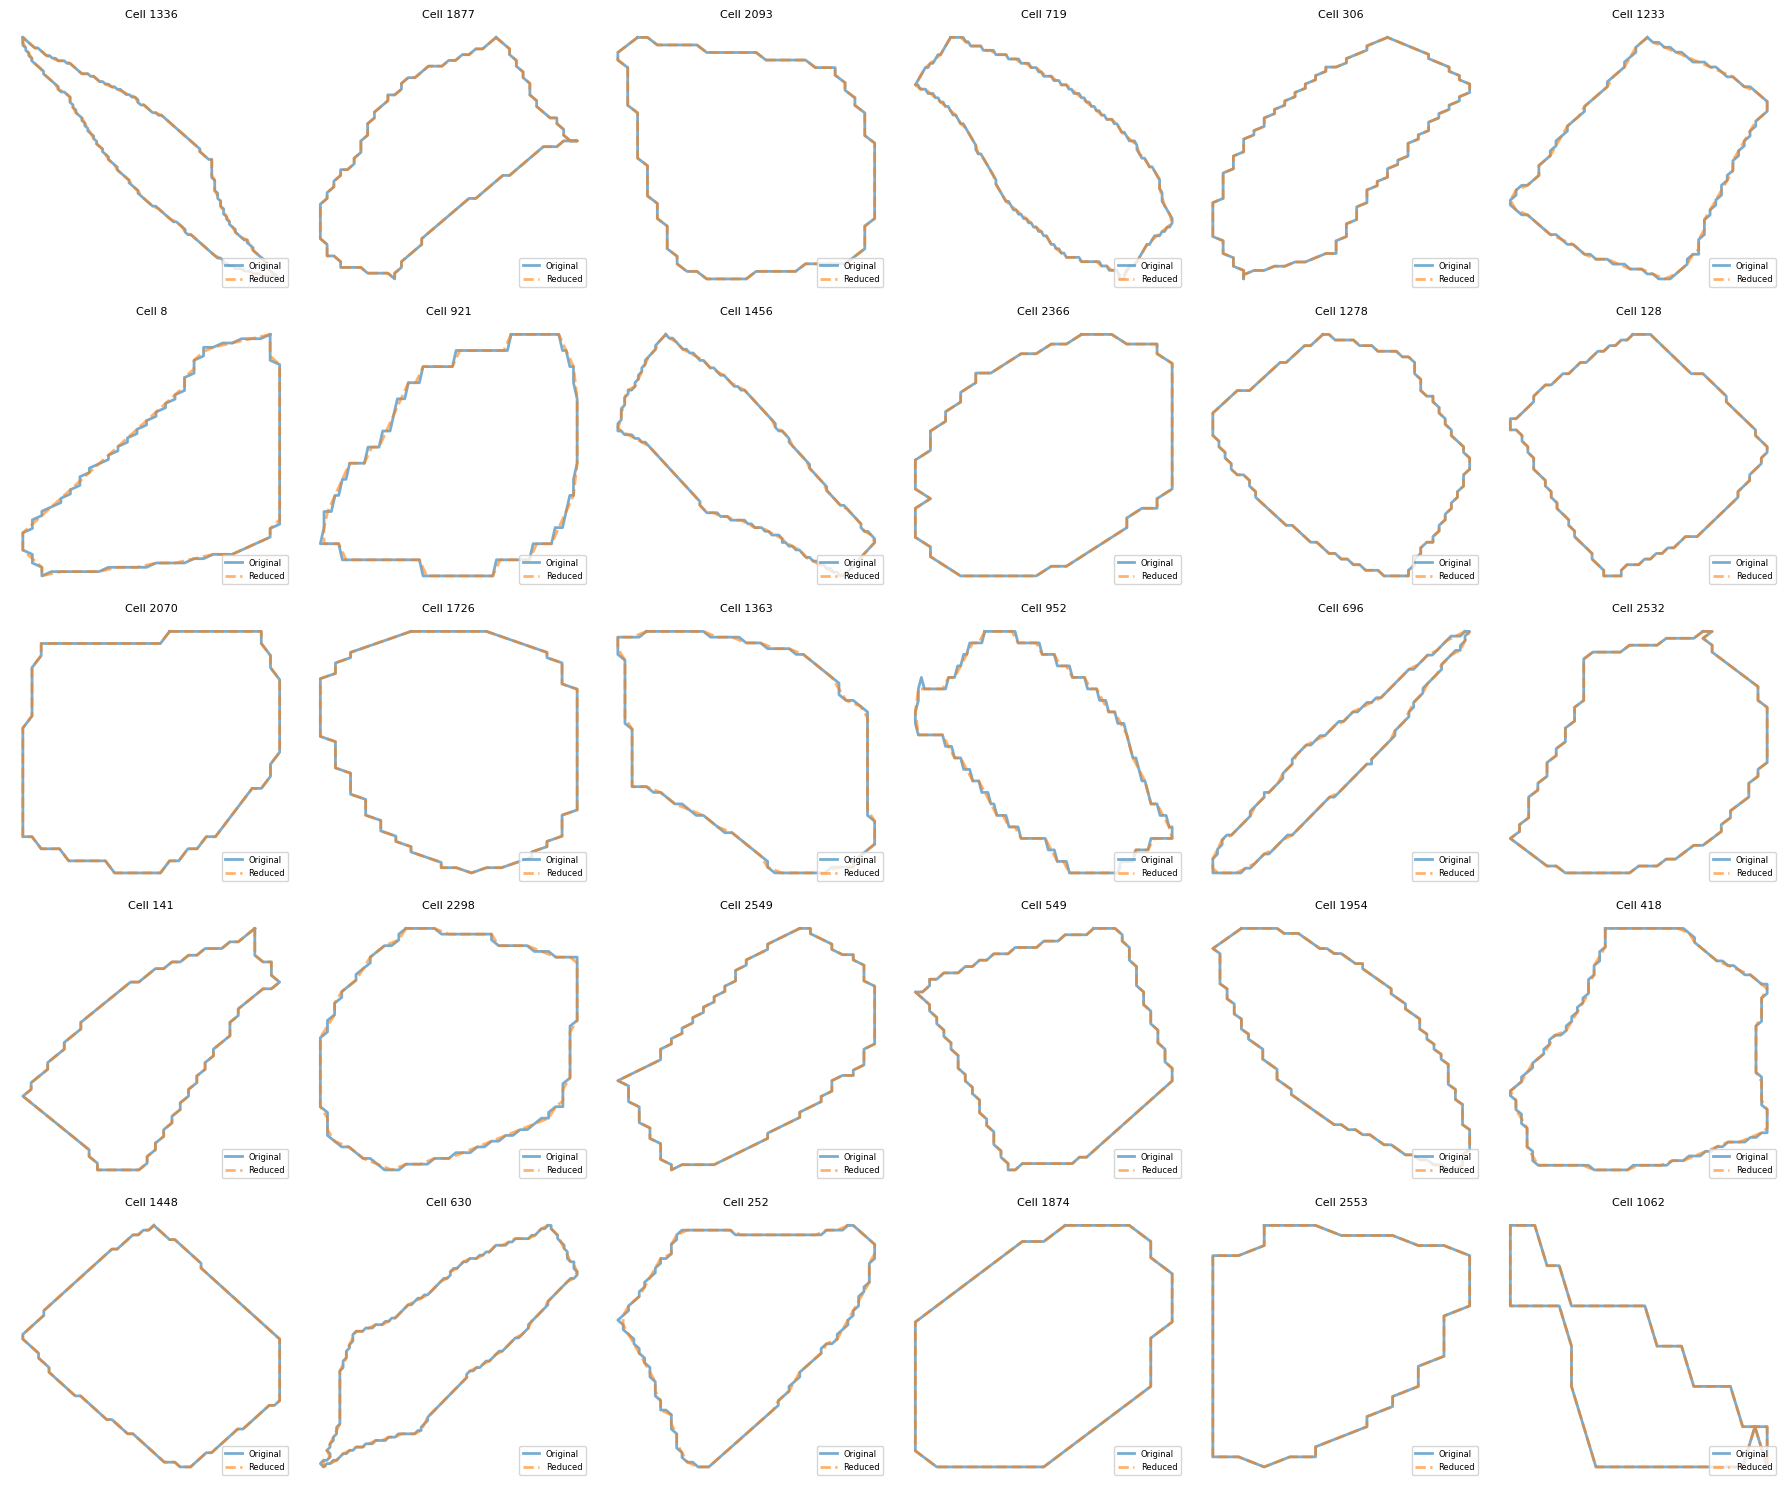

In [ ]:
# Visulize before reduce size
import matplotlib.pyplot as plt
import numpy as np

def plot_cell_outlines_comparison(df_orig, df_reduced, n=30, rows=5, cols=6):
    # find cell IDs present in both dataframes
    common_ids = np.intersect1d(df_orig['cell_id'].unique(),
                                df_reduced['cell_id'].unique())
    # sample up to n cells
    ids = np.random.choice(common_ids, min(n, len(common_ids)), replace=False)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    axes = axes.flatten()
    for ax, cell_id in zip(axes, ids):
        orig = df_orig[df_orig['cell_id'] == cell_id]
        red  = df_reduced[df_reduced['cell_id'] == cell_id]

        # original outline
        ax.plot(orig['vertex_x'], orig['vertex_y'],
                linewidth=2, label='Original', alpha=0.6)
        # reduced outline
        ax.plot(red['vertex_x'],  red['vertex_y'],
                linewidth=2, linestyle='--', label='Reduced', alpha=0.6)

        ax.set_title(f'Cell {cell_id}', fontsize=8)
        ax.invert_yaxis()
        ax.axis('off')
        ax.legend(loc='lower right', fontsize=6)

    # turn off any extra axes
    for ax in axes[len(ids):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# usage
plot_cell_outlines_comparison(df_outlines_list, reduced_outlines_list)



In [ ]:
reduced_outlines_list.to_csv(f'{ddir}/segmenatation/{sample_name}/cellpose_cell_boundaries_{sample_name}.csv', index=False)
print("Saved successly" )

Saved successly


In [ ]:
unique_cell_count = reduced_outlines_list['cell_id'].nunique()
# unique_cell_count = boundary_df['cell_id'].nunique()

unique_cell_count

2555

In [ ]:
# Calculate centroids for each cell
centroids_df = calculate_centroids(reduced_outlines_list)
centroids_df

,cell_id,centroid_x,centroid_y
0,1,7056.823529,4687.955882
1,2,6999.539130,4719.756522
2,3,7045.062500,4719.875000
3,4,7057.220588,4738.220588
4,5,6975.789474,4758.736842
...,...,...,...
2550,2551,18201.873016,16167.380952
2551,2552,18206.537313,16196.686567
2552,2553,18184.947368,16196.035088
2553,2554,18211.739726,16221.232877


In [ ]:
centroids_df_scaled = centroids_df.copy()
rescale_factor = 0.2125
centroids_df_scaled['centroid_x'] *= rescale_factor
centroids_df_scaled['centroid_y'] *= rescale_factor

In [ ]:
centroids_df_scaled.to_csv(f'{ddir}/segmenatation/{sample_name}/cellpose_cell_centroids_{sample_name}.csv', index=False)
print("Saved successly" )

Saved successly


In [ ]:
# Process to append the first row of each cell group
Outlines_list_final = (
    reduced_outlines_list.groupby('cell_id', group_keys=False)
    .apply(lambda group: pd.concat([group, group.iloc[[0]]], ignore_index=True))
)

Outlines_list_final

C:\Users\Alexis\AppData\Local\Temp\ipykernel_24352\3904916442.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda group: pd.concat([group, group.iloc[[0]]], ignore_index=True))


,cell_id,vertex_x,vertex_y
0,1,7073,4665
1,1,7071,4666
2,1,7069,4667
3,1,7067,4668
4,1,7065,4669
...,...,...,...
73,2555,18186,16216
74,2555,18185,16215
75,2555,18184,16215
76,2555,18183,16215


In [ ]:
Outlines_list_final_scaled = Outlines_list_final.copy()
rescale_factor = 0.2125
Outlines_list_final_scaled['vertex_x'] *= rescale_factor
Outlines_list_final_scaled['vertex_y'] *= rescale_factor

In [ ]:
Outlines_list_final.to_csv(f'{ddir}/segmenatation/{sample_name}/cellpose_cell_boundaries_pixel_{sample_name}.csv', index=False)
print("Saved successly" )

Saved successly


In [ ]:
Outlines_list_final_scaled.to_csv(f'{ddir}/segmenatation/{sample_name}/cellpose_cell_boundaries_{sample_name}.csv', index=False)
print("Saved successly" )

Saved successly


## Assign Transcripts

In [ ]:
import pandas as pd
boundaries_df_origin = pd.read_csv(f'{ddir}/segmenatation/{sample_name}/cellpose_cell_boundaries_{sample_name}.csv')
print("Data boundaries table file successfully")

boundaries_df_origin

Data boundaries table file successfully


,cell_id,vertex_x,vertex_y
0,1,1503.0125,991.3125
1,1,1502.5875,991.5250
2,1,1502.1625,991.7375
3,1,1501.7375,991.9500
4,1,1501.3125,992.1625
...,...,...,...
217327,2555,3864.5250,3445.9000
217328,2555,3864.3125,3445.6875
217329,2555,3864.1000,3445.6875
217330,2555,3863.8875,3445.6875


In [ ]:
boundaries_df = boundaries_df_origin

In [ ]:
transcripts_original = pd.read_parquet(f'{base_path}/transcripts.parquet')

# Print information about the data frame
transcripts_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37290951 entries, 0 to 37290950
Data columns (total 13 columns):
 #   Column             Dtype  
---  ------             -----  
 0   transcript_id      uint64 
 1   cell_id            object 
 2   overlaps_nucleus   uint8  
 3   feature_name       object 
 4   x_location         float32
 5   y_location         float32
 6   z_location         float32
 7   qv                 float32
 8   fov_name           object 
 9   nucleus_distance   float32
 10  codeword_index     int32  
 11  codeword_category  object 
 12  is_gene            bool   
dtypes: bool(1), float32(5), int32(1), object(4), uint64(1), uint8(1)
memory usage: 2.3+ GB


In [ ]:
# Filter transcripts with qv score > 20
transcripts_b4_assign = transcripts_original[transcripts_original['qv'] > 20]

# Print information about the filtered dataframe
print("Original number of transcripts:", len(transcripts_original))
print("Number of transcripts after filtering (qv > 20):", len(transcripts_b4_assign))
print("\nPercentage of transcripts retained:", 
      round(len(transcripts_b4_assign) / len(transcripts_original) * 100, 2), "%")

# Display first few rows of filtered dataframe
print("\nFirst few rows of filtered data:")
print(transcripts_b4_assign.head())

Original number of transcripts: 37290951
Number of transcripts after filtering (qv > 20): 29595865

Percentage of transcripts retained: 79.36 %

First few rows of filtered data:
     transcript_id     cell_id  overlaps_nucleus feature_name  x_location  \
0  281552286260560  UNASSIGNED                 0        Actr2  198.421875   
1  281552286220304  UNASSIGNED                 0        Amer1  170.265625   
2  281552286481611  UNASSIGNED                 0         Amfr  242.515625   
3  281552286186492  UNASSIGNED                 0          Ank   19.312500   
4  281552286352767  UNASSIGNED                 0       Atp2b4  215.406250   

    y_location  z_location     qv fov_name  nucleus_distance  codeword_index  \
0  2894.703125   12.125000  27.75      P11        346.203125            2466   
1  2900.140625   12.156250  40.00      P11        344.437500            6875   
2  2968.218750   12.515625  27.25      P11        271.593750           15224   
3  2962.734375   12.234375  40.00      

In [ ]:
processed_count = 0


In [ ]:
import pandas as pd
from shapely.geometry import Point, Polygon
from shapely.prepared import prep

# 1) Load your polygon
polygon_coords = pd.read_csv(f"{base_path}/{sample_name}_coords.csv")
polygon = Polygon(zip(polygon_coords['X'], polygon_coords['Y']))

# 2) Build the bounding‐box filter
minx, miny, maxx, maxy = polygon.bounds

# 3) Prepare the polygon for fast repeated contains() checks
prepared_poly = prep(polygon)

# 4) Load transcripts
df = transcripts_b4_assign.copy()

# 5) First, prefilter by bbox (very cheap)
mask_bbox = (
    (df["x_location"] >= minx) &
    (df["x_location"] <= maxx) &
    (df["y_location"] >= miny) &
    (df["y_location"] <= maxy)
)
df_bbox = df[mask_bbox]

print(f"{len(df_bbox)} of {len(df)} points lie in the bbox, now doing exact test…")

# 6) Now do the exact point-in-polygon test with a simple list comprehension
from tqdm import tqdm
filtered = []
for x, y in tqdm(zip(df_bbox["x_location"], df_bbox["y_location"]),
                 total=len(df_bbox)):
    pt = Point(x, y)
    if prepared_poly.contains(pt):
        filtered.append(True)
    else:
        filtered.append(False)

transcripts_filtered = df_bbox[filtered]
print(f"Kept {len(transcripts_filtered)} points inside the actual polygon.")


11370046 of 29595865 points lie in the bbox, now doing exact test…


100%|██████████| 11370046/11370046 [04:42<00:00, 40282.98it/s]


Kept 2213966 points inside the actual polygon.


In [ ]:
transcripts_filtered

,transcript_id,cell_id,overlaps_nucleus,feature_name,x_location,y_location,z_location,qv,fov_name,nucleus_distance,codeword_index,codeword_category,is_gene
1937080,281483566672822,UNASSIGNED,0,2610528A11Rik,999.562500,1430.343750,13.156250,40.00,M12,10.250000,3438,custom_gene,True
1937081,281509336838006,dpblpdjf-1,1,2610528A11Rik,996.750000,1467.906250,14.703125,32.50,N12,0.000000,3438,custom_gene,True
1937082,281483566685402,dpblpdjf-1,0,2610528A11Rik,998.109375,1463.312500,18.468750,38.75,M12,0.421875,6202,custom_gene,True
1937083,281483566794181,UNASSIGNED,0,2610528A11Rik,996.000000,1440.812500,13.031250,40.00,M12,2.625000,6202,custom_gene,True
1937084,281509336729749,dopppbfe-1,1,2610528A11Rik,988.093750,1486.843750,21.421875,29.75,N12,0.000000,6202,custom_gene,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
37275645,281578057397395,fjeehnab-1,0,UnassignedCodeword_17432,4014.531250,3112.359375,18.062500,27.00,P17,1.468750,17432,unassigned_codeword,False
37275646,281578057108144,fiphjefn-1,1,UnassignedCodeword_17785,4031.390625,3017.359375,18.015625,22.00,P17,0.000000,17785,unassigned_codeword,False
37275647,281578055937403,acmokccm-1,0,UnassignedCodeword_18643,4013.359375,3077.875000,22.578125,29.75,P17,0.296875,18643,unassigned_codeword,False
37275648,281578056890360,UNASSIGNED,0,DeprecatedCodeword_0321,4007.921875,3037.843750,20.546875,28.00,P17,1.593750,321,deprecated_codeword,False


In [ ]:
transcripts_assigned = transcripts_filtered
transcripts_assigned

,transcript_id,cell_id,overlaps_nucleus,feature_name,x_location,y_location,z_location,qv,fov_name,nucleus_distance,codeword_index,codeword_category,is_gene
1937080,281483566672822,UNASSIGNED,0,2610528A11Rik,999.562500,1430.343750,13.156250,40.00,M12,10.250000,3438,custom_gene,True
1937081,281509336838006,dpblpdjf-1,1,2610528A11Rik,996.750000,1467.906250,14.703125,32.50,N12,0.000000,3438,custom_gene,True
1937082,281483566685402,dpblpdjf-1,0,2610528A11Rik,998.109375,1463.312500,18.468750,38.75,M12,0.421875,6202,custom_gene,True
1937083,281483566794181,UNASSIGNED,0,2610528A11Rik,996.000000,1440.812500,13.031250,40.00,M12,2.625000,6202,custom_gene,True
1937084,281509336729749,dopppbfe-1,1,2610528A11Rik,988.093750,1486.843750,21.421875,29.75,N12,0.000000,6202,custom_gene,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
37275645,281578057397395,fjeehnab-1,0,UnassignedCodeword_17432,4014.531250,3112.359375,18.062500,27.00,P17,1.468750,17432,unassigned_codeword,False
37275646,281578057108144,fiphjefn-1,1,UnassignedCodeword_17785,4031.390625,3017.359375,18.015625,22.00,P17,0.000000,17785,unassigned_codeword,False
37275647,281578055937403,acmokccm-1,0,UnassignedCodeword_18643,4013.359375,3077.875000,22.578125,29.75,P17,0.296875,18643,unassigned_codeword,False
37275648,281578056890360,UNASSIGNED,0,DeprecatedCodeword_0321,4007.921875,3037.843750,20.546875,28.00,P17,1.593750,321,deprecated_codeword,False


In [ ]:
import pandas as pd
from shapely.geometry import Point, Polygon
from rtree import index

# 1) Build spatial index and polygon dict
spatial_idx = index.Index()
cell_polygons = {}

for cell_id, group in Outlines_list_final_scaled.groupby("cell_id"):
    poly = Polygon(zip(group["vertex_x"], group["vertex_y"]))
    cell_polygons[cell_id] = poly
    spatial_idx.insert(cell_id, poly.bounds)

# 2) Helper: single‐point lookup (no globals here)
def find_cell_id(x, y, spatial_index, polygons):
    pt = Point(x, y)
    # only test the few polygons whose bbox overlaps this point
    for cid in spatial_index.intersection((x, y, x, y)):
        if polygons[cid].contains(pt):
            return cid
    return "UNASSIGNED"

# 3) Main assigner with progress tracking
def assign_cell_ids_with_progress(df, spatial_index, polygons):
    """
    Iterates over df, finds each point’s cell_id via R-tree lookup,
    and shows a tqdm progress bar.
    Returns a list of cell_ids in the same order as df.
    """
    cell_ids = []
    # wrap the iterator in tqdm, giving a description and total count
    for row in tqdm(df.itertuples(index=False),
                    total=len(df),
                    desc="Assigning transcripts"):
        x, y = row.x_location, row.y_location
        pt = Point(x, y)
        # only test candidate polygons whose bbox overlaps this point
        cid = "UNASSIGNED"
        for candidate in spatial_index.intersection((x, y, x, y)):
            if polygons[candidate].contains(pt):
                cid = candidate
                break
        cell_ids.append(cid)

    return cell_ids

# Execution
transcripts_assigned["cell_id"] = assign_cell_ids_with_progress(
    transcripts_assigned,
    spatial_idx,
    cell_polygons
)
print("✅ Processing complete! All transcripts have been assigned a cell_id.")


Assigning transcripts: 100%|██████████| 2213966/2213966 [03:42<00:00, 9939.12it/s] 


✅ Processing complete! All transcripts have been assigned a cell_id.


C:\Users\Alexis\AppData\Local\Temp\ipykernel_24352\1146600327.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transcripts_assigned["cell_id"] = assign_cell_ids_with_progress(


In [ ]:
transcripts_assigned_true = transcripts_assigned[transcripts_assigned["cell_id"] != "UNASSIGNED"]
transcripts_assigned_true

,transcript_id,cell_id,overlaps_nucleus,feature_name,x_location,y_location,z_location,qv,fov_name,nucleus_distance,codeword_index,codeword_category,is_gene
1937081,281509336838006,271,1,2610528A11Rik,996.750000,1467.906250,14.703125,32.50,N12,0.000000,3438,custom_gene,True
1937082,281483566685402,264,0,2610528A11Rik,998.109375,1463.312500,18.468750,38.75,M12,0.421875,6202,custom_gene,True
1937084,281509336729749,283,1,2610528A11Rik,988.093750,1486.843750,21.421875,29.75,N12,0.000000,6202,custom_gene,True
1937085,281509336730187,258,0,2610528A11Rik,999.437500,1448.437500,13.078125,40.00,N12,0.656250,6202,custom_gene,True
1937087,281509337327125,286,1,2610528A11Rik,984.968750,1489.359375,21.015625,36.75,N12,0.000000,6202,custom_gene,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
37275643,281578056968564,2365,0,UnassignedCodeword_16670,4009.171875,3042.625000,24.828125,25.00,P17,0.671875,16670,unassigned_codeword,False
37275644,281578056077104,2371,0,UnassignedCodeword_17113,4012.781250,3058.859375,24.062500,28.25,P17,1.000000,17113,unassigned_codeword,False
37275646,281578057108144,2349,1,UnassignedCodeword_17785,4031.390625,3017.359375,18.015625,22.00,P17,0.000000,17785,unassigned_codeword,False
37275647,281578055937403,2382,0,UnassignedCodeword_18643,4013.359375,3077.875000,22.578125,29.75,P17,0.296875,18643,unassigned_codeword,False


In [ ]:
import pandas as pd
import os

def create_folder_if_not_exists(path):
    """Create folder if it doesn't exist."""
    if not os.path.exists(path):
        os.makedirs(path)
        print(f"Created directory: {path}")

gene_output_dir = f"{ddir}/gene_expression_matrix/{sample_name}"
create_folder_if_not_exists(gene_output_dir)

Created directory: D:\Alexis\Projects\SpatialOmics_cellpose\results/gene_expression_matrix/1902od


In [ ]:
# Assuming transcripts_assigned_ture is your DataFrame
output_path = f"{ddir}/gene_expression_matrix/{sample_name}/transcripts_assigned_ture.parquet"

# Save the DataFrame as a Parquet file
transcripts_assigned_true.to_parquet(output_path, engine='pyarrow', index=False)

print(f"DataFrame saved successfully to {output_path}")

DataFrame saved successfully to D:\Alexis\Projects\SpatialOmics_cellpose\results/gene_expression_matrix/1902od/transcripts_assigned_ture.parquet


In [ ]:
transcripts_data = transcripts_assigned_true

# Create a pivot table for the gene expression matrix
gene_expression_matrix = (
    transcripts_data.groupby(["cell_id", "feature_name"])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

# Add total counts column

gene_expression_matrix["Total Counts"] = gene_expression_matrix.drop(columns=["cell_id"]).sum(axis=1)

# Merge with centroids to add centroid coordinates
gene_expression_matrix = pd.merge(
    
    centroids_df,
    gene_expression_matrix,
    left_on="cell_id", 
    right_on="cell_id", 
    how='left')

In [ ]:
gene_expression_matrix

,cell_id,centroid_x,centroid_y,2610528A11Rik,A1cf,A2m,Aatf,Abca1,Abca13,Abca3,...,Zmynd19,Zscan2,Zscan21,Zswim5,Zswim9,Zup1,Zyx,Zzef1,a,Total Counts
0,1,7056.823529,4687.955882,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,904.0
1,2,6999.539130,4719.756522,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1567.0
2,3,7045.062500,4719.875000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,816.0
3,4,7057.220588,4738.220588,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,722.0
4,5,6975.789474,4758.736842,2.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1118.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2550,2551,18201.873016,16167.380952,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0
2551,2552,18206.537313,16196.686567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0
2552,2553,18184.947368,16196.035088,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2553,2554,18211.739726,16221.232877,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0


In [ ]:
later_columns = gene_expression_matrix.columns[1:]

In [ ]:
# Fill empty values with 0 for all columns after column 4
gene_expression_matrix[later_columns] = gene_expression_matrix[later_columns].fillna(0)

# Verify the changes
print("\nChecking if there are still any empty values:")
print(gene_expression_matrix[later_columns].isna().sum())

# Display a few rows to verify the changes
print("\nFirst few rows after filling empty values:")
print(gene_expression_matrix.head())


Checking if there are still any empty values:
centroid_x       0
centroid_y       0
2610528A11Rik    0
A1cf             0
A2m              0
                ..
Zup1             0
Zyx              0
Zzef1            0
a                0
Total Counts     0
Length: 6468, dtype: int64

First few rows after filling empty values:
   cell_id   centroid_x   centroid_y  2610528A11Rik  A1cf  A2m  Aatf  Abca1  \
0        1  7056.823529  4687.955882            0.0   0.0  0.0   0.0    0.0   
1        2  6999.539130  4719.756522            1.0   0.0  0.0   0.0    0.0   
2        3  7045.062500  4719.875000            0.0   0.0  0.0   0.0    0.0   
3        4  7057.220588  4738.220588            0.0   0.0  0.0   0.0    0.0   
4        5  6975.789474  4758.736842            2.0   0.0  0.0   0.0    0.0   

   Abca13  Abca3  ...  Zmynd19  Zscan2  Zscan21  Zswim5  Zswim9  Zup1  Zyx  \
0     0.0    0.0  ...      0.0     0.0      0.0     0.0     0.0   0.0  0.0   
1     0.0    1.0  ...      0.0     0.0    

In [ ]:
import pandas as pd

# Assuming transcripts_assigned_ture is your DataFrame
output_path = rf"{ddir}/gene_expression_matrix/{sample_name}/{sample_name}_gene_expression_matrix.csv"

# Save the DataFrame as a Parquet file
gene_expression_matrix.to_csv(output_path, index=False)

print(f"DataFrame saved successfully to {output_path}")

DataFrame saved successfully to D:\Alexis\Projects\SpatialOmics_cellpose\results/gene_expression_matrix/1902od/1902od_gene_expression_matrix.csv
